### Part 0: Housekeeping

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
#excel_path = "/content/drive/MyDrive/aggregateRockData.xlsx"
#categories_df = pd.read_excel(excel_path, usecols="A", nrows=480)
#categories_df.columns = ["Category"]

In [49]:
# Load the label data
## 2nd column: rock category number (1 = Igneous, 2 = Metamorphic, 3 = Sedimentary
labeldata = pd.read_excel("/content/drive/MyDrive/aggregateRockData.xlsx",
                          usecols=[1], nrows=480)
labeldata.rename(columns={labeldata.columns[0]: "Category"}, inplace=True)

# Load the feature data
feature_path = "/content/drive/MyDrive/feature_presence540.txt"
features_df = pd.read_csv(
    feature_path,
    sep=r"\s+",
    header=None,
    comment=None
)
features_df = features_df.iloc[:480, 2:14]
feature_names = [
    "Token number", "Angular fragments", "Rounded fragments",
    "Straight stripes", "Curved stripes", "Physical layers",
    "Veins", "Oily/shimmery texture", "Splotchy texture",
    "Single translucent crystal", "Multiple cubic crystals",
    "Sandy texture"
]
features_df.columns = feature_names

# Combine with categories
full_df = pd.concat([labeldata, features_df], axis=1)

### Part 1: Summary Stats

In [55]:
full_df.head()

,Category,Token number,Angular fragments,Rounded fragments,Straight stripes,Curved stripes,Physical layers,Veins,Oily/shimmery texture,Splotchy texture,Single translucent crystal,Multiple cubic crystals,Sandy texture
0,1,1,0.20,0.15,0.00,0.0,0.00,0.05,0.0,0.30,0.0,0.00,0.10
1,1,2,0.65,0.15,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.05,0.05
2,1,3,0.60,0.00,0.00,0.0,0.05,0.00,0.0,0.35,0.0,0.00,0.05
3,1,4,0.10,0.85,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.00,0.10
4,1,5,0.35,0.80,0.00,0.0,0.00,0.00,0.0,0.10,0.0,0.00,0.05


In [56]:
# Melt into long format
feature_cols = full_df.columns.difference(['Category', 'Token number'])
long_df = full_df.melt(value_vars=feature_cols, var_name='Feature', value_name='Value')

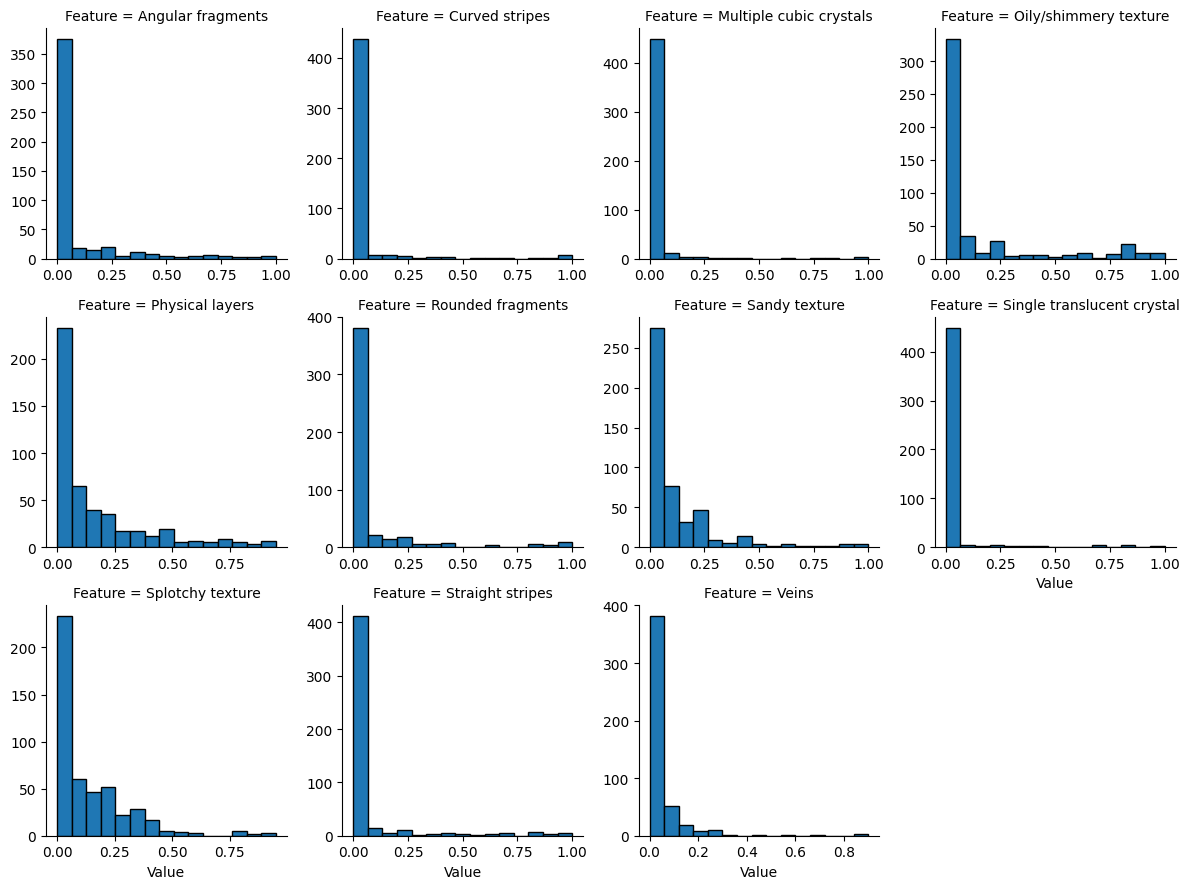

In [57]:
# Custom histogram plotting function
def conditional_custom_hist(data, **kwargs):
    ax = plt.gca()
    data = pd.Series(data).dropna().astype(float)
    plt.hist(data, bins=15, edgecolor='black')
    feature = kwargs.get('label')  # automatically passed by FacetGrid

    # Add custom x-ticks only to selected features
    if feature in ["Angular fragments", "Rounded fragments", "Straight stripes"]:
        min_val = data.min()
        median_val = data.median()
        max_val = data.max()
        ax.set_xticks([min_val, median_val, max_val])
        ax.set_xticklabels([f'{min_val:.2f}', f'{median_val:.2f}', f'{max_val:.2f}'])

# Create facet grid of histograms
g = sns.FacetGrid(long_df, col='Feature', col_wrap=4, sharex=False, sharey=False)
g.map(conditional_custom_hist, 'Value')

# Adjust layout and display
plt.tight_layout()
plt.show()

All of the features appear to be right skewed. I could go and transform all of them, but I don't think it is warranted. One, the range for all the features seem to range from 0 to 1. So, the magnitude isn't too extereme. Second, I don't think any of the models we will be using follow any assumptions about the normality of the predictors.

In [58]:
feature_summary = full_df.drop(columns=['Category', 'Token number']).describe()
feature_summary

,Curved stripes,Physical layers,Veins,Oily/shimmery texture,Splotchy texture,Single translucent crystal,Multiple cubic crystals,Sandy texture
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.042292,0.165146,0.052396,0.144479,0.141458,0.031667,0.025104,0.119854
std,0.160970,0.216635,0.102676,0.265689,0.168222,0.135647,0.112153,0.173149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.050000
75%,0.000000,0.212500,0.050000,0.100000,0.200000,0.000000,0.000000,0.150000
max,1.000000,0.950000,0.900000,1.000000,0.950000,1.000000,1.000000,1.000000


Yeah, pretty much just the same information that the histogram tells us.

### Part 2: Relationships

In [62]:
corrmat = full_df.drop(columns=['Category', 'Token number']).corr()
round(corrmat, 2)

,Angular fragments,Rounded fragments,Straight stripes,Curved stripes,Physical layers,Veins,Oily/shimmery texture,Splotchy texture,Single translucent crystal,Multiple cubic crystals,Sandy texture
Angular fragments,1.00,0.25,-0.13,-0.10,-0.23,-0.12,-0.15,0.06,-0.09,-0.02,-0.17
Rounded fragments,0.25,1.00,-0.12,-0.08,-0.24,-0.14,-0.14,0.01,-0.09,-0.04,-0.14
Straight stripes,-0.13,-0.12,1.00,0.20,-0.03,0.04,-0.11,-0.14,-0.03,-0.07,0.11
Curved stripes,-0.10,-0.08,0.20,1.00,-0.13,0.05,-0.07,-0.12,-0.06,-0.06,-0.07
Physical layers,-0.23,-0.24,-0.03,-0.13,1.00,0.06,0.18,-0.30,-0.10,-0.13,-0.04
Veins,-0.12,-0.14,0.04,0.05,0.06,1.00,-0.10,0.04,-0.01,-0.09,-0.05
Oily/shimmery texture,-0.15,-0.14,-0.11,-0.07,0.18,-0.10,1.00,-0.22,-0.02,-0.04,-0.32
Splotchy texture,0.06,0.01,-0.14,-0.12,-0.30,0.04,-0.22,1.00,-0.07,-0.07,-0.17
Single translucent crystal,-0.09,-0.09,-0.03,-0.06,-0.10,-0.01,-0.02,-0.07,1.00,0.12,-0.13
Multiple cubic crystals,-0.02,-0.04,-0.07,-0.06,-0.13,-0.09,-0.04,-0.07,0.12,1.00,-0.12


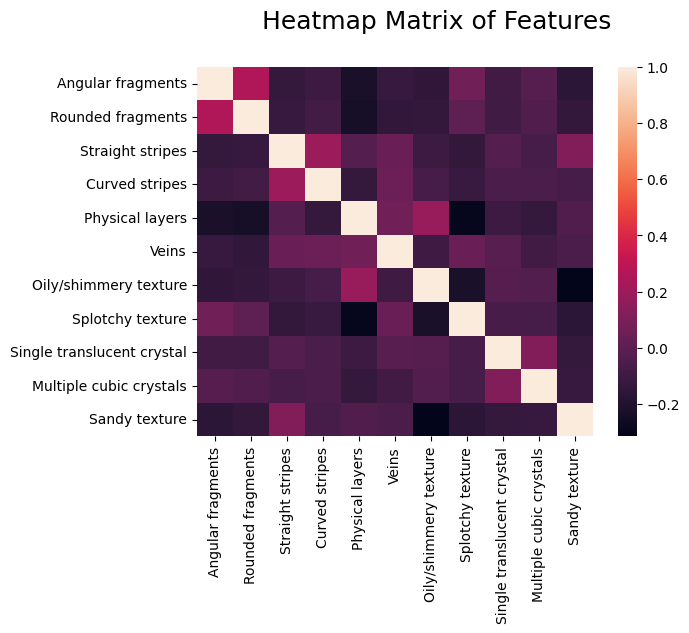

In [63]:
sns.heatmap(corrmat)
plt.suptitle("Heatmap Matrix of Features", y = 1, fontsize = 18)
plt.show()

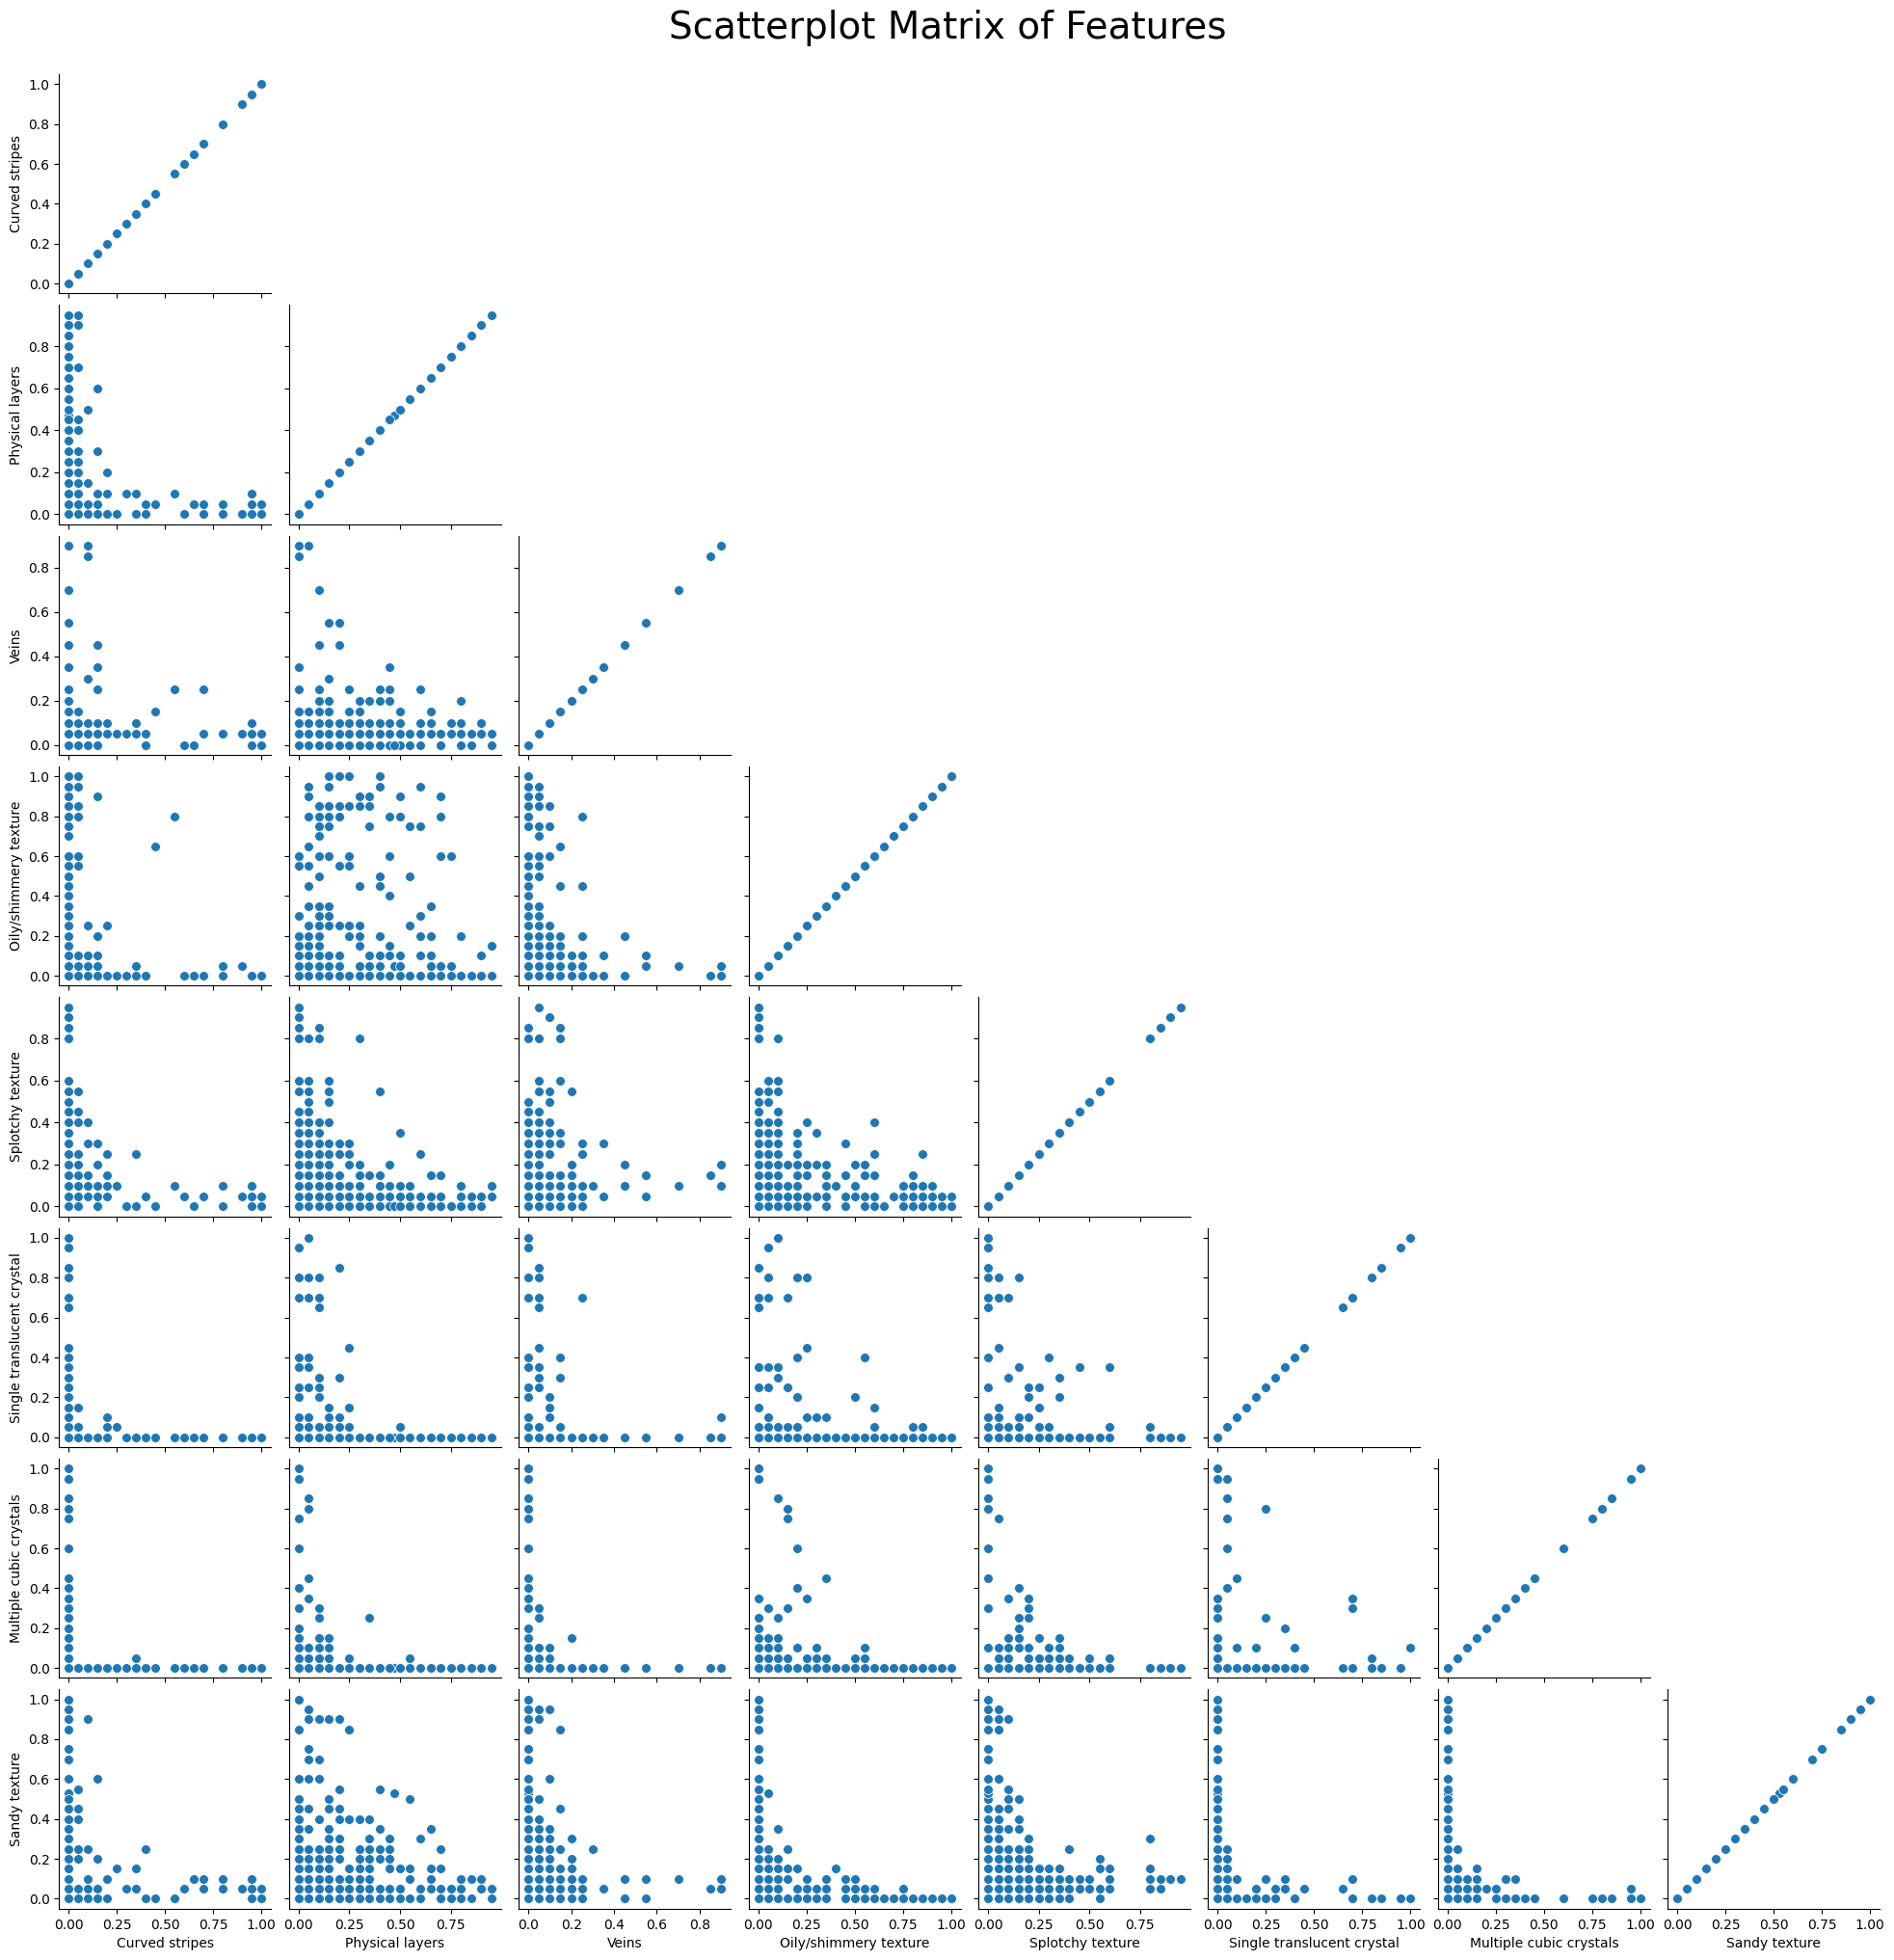

In [64]:
# Drops the categorical variables
features_only_df = full_df.drop(columns=["Category", "Token number"])

# Creates a scatterplot matrix of the remaining features
sns.pairplot(features_only_df, corner=True, diag_kind=None, plot_kws={'s': 50})
plt.suptitle("Scatterplot Matrix of Features", y=1.02, fontsize = 28)
plt.show()

All three matrices tell us the same story: there is little to no corrlation between the variables. This is a good thing, because we don't expect the features to be related at all.

### Part 3: Splitting the data

In [77]:
# Assign proper class labels for each rock subtype
# Each 16 rows belong to a different category (30 subtypes × 16 = 480 rows)
full_df['Class'] = (full_df.index // 16).astype(str)
full_df["Token number"] = full_df["Token number"].astype(int)
# creates empty lists for the different sets of the data
train_list, val_list, test_list = [], [], []

# loops through the data to fill the sets following what the description says
for _, group in full_df.groupby("Category"):
    group_sorted = group.sort_values("Token number")
    train_list.append(group_sorted[group_sorted["Token number"].between(1, 10)])
    val_list.append(group_sorted[group_sorted["Token number"].between(11, 13)])
    test_list.append(group_sorted[group_sorted["Token number"].between(14, 16)])

# Combine each list into a DataFrame
train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

# Verify the shapes
train_df.shape, val_df.shape, test_df.shape

((300, 14), (90, 14), (90, 14))

### Part 4: Classifiers

#### 4.1: Softmax Regression

In [78]:
# Prepare features and labels
X_train = train_df[feature_cols]
y_train = train_df['Class']
X_val = val_df[feature_cols]
y_val = val_df['Class']
X_test = test_df[feature_cols]
y_test = test_df['Class']

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Encode class labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Train base multinomial logistic regression model
base_model = LogisticRegression(C = 1, solver='lbfgs', max_iter=1000)
base_model.fit(X_train, y_train_enc)

# Predictions
y_train_pred = base_model.predict(X_train)
y_val_pred = base_model.predict(X_val)
y_test_pred = base_model.predict(X_test)

In [79]:
metrics = {
    "Set": ["Train", "Validation", "Test"],
    "Accuracy": [
        accuracy_score(y_train_enc, y_train_pred),
        accuracy_score(y_val_enc, y_val_pred),
        accuracy_score(y_test_enc, y_test_pred)
    ],
    "Precision": [
        precision_score(y_train_enc, y_train_pred, average='macro', zero_division=0),
        precision_score(y_val_enc, y_val_pred, average='macro', zero_division=0),
        precision_score(y_test_enc, y_test_pred, average='macro', zero_division=0)
    ],
    "Recall": [
        recall_score(y_train_enc, y_train_pred, average='macro', zero_division=0),
        recall_score(y_val_enc, y_val_pred, average='macro', zero_division=0),
        recall_score(y_test_enc, y_test_pred, average='macro', zero_division=0)
    ],
    "F1 Score": [
        f1_score(y_train_enc, y_train_pred, average='macro', zero_division=0),
        f1_score(y_val_enc, y_val_pred, average='macro', zero_division=0),
        f1_score(y_test_enc, y_test_pred, average='macro', zero_division=0)
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Set,Accuracy,Precision,Recall,F1 Score
0,Train,0.440000,0.397270,0.440000,0.360885
1,Validation,0.377778,0.258690,0.377778,0.283884
2,Test,0.444444,0.349802,0.444444,0.354690


In [80]:
solvers = ['lbfgs', 'newton-cg', 'sag', 'saga']
C_values = [0.01, 0.1, 1, 10, 100]
max_iter_values = [50, 100, 300, 500, 1000]

# Extend the grid search to include training and test metrics
extended_grid_results = []

for solver in solvers:
    for C in C_values:
        for max_iter in max_iter_values:
            try:
                model = LogisticRegression(C=C, solver=solver, max_iter=max_iter)
                model.fit(X_train, y_train_enc)

                # Validation prediction
                y_val_pred = model.predict(X_val)
                # Training prediction
                y_train_pred = model.predict(X_train)
                # Test prediction
                y_test_pred = model.predict(X_test)

                extended_grid_results.append({
                    "Solver": solver,
                    "C": C,
                    "max_iter": max_iter,

                    # Validation metrics
                    "Val Accuracy": accuracy_score(y_val_enc, y_val_pred),
                    "Val Precision": precision_score(y_val_enc, y_val_pred, average='macro', zero_division=0),
                    "Val Recall": recall_score(y_val_enc, y_val_pred, average='macro', zero_division=0),
                    "Val F1": f1_score(y_val_enc, y_val_pred, average='macro', zero_division=0),

                    # Train metrics
                    "Train Accuracy": accuracy_score(y_train_enc, y_train_pred),
                    "Train Precision": precision_score(y_train_enc, y_train_pred, average='macro', zero_division=0),
                    "Train Recall": recall_score(y_train_enc, y_train_pred, average='macro', zero_division=0),
                    "Train F1": f1_score(y_train_enc, y_train_pred, average='macro', zero_division=0),

                    # Test metrics
                    "Test Accuracy": accuracy_score(y_test_enc, y_test_pred),
                    "Test Precision": precision_score(y_test_enc, y_test_pred, average='macro', zero_division=0),
                    "Test Recall": recall_score(y_test_enc, y_test_pred, average='macro', zero_division=0),
                    "Test F1": f1_score(y_test_enc, y_test_pred, average='macro', zero_division=0)
                })
            except Exception as e:
                extended_grid_results.append({
                    "Solver": solver,
                    "C": C,
                    "max_iter": max_iter,
                    "Val Accuracy": None,
                    "Val Precision": None,
                    "Val Recall": None,
                    "Val F1": None,
                    "Train Accuracy": None,
                    "Train Precision": None,
                    "Train Recall": None,
                    "Train F1": None,
                    "Test Accuracy": None,
                    "Test Precision": None,
                    "Test Recall": None,
                    "Test F1": None,
                    "Error": str(e)
                })

# Create and display DataFrame
extended_df = pd.DataFrame(extended_grid_results).round(2)
extended_df.head()


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef

,Solver,C,max_iter,Val Accuracy,Val Precision,Val Recall,Val F1,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,lbfgs,0.01,50,0.28,0.15,0.28,0.17,0.3,0.17,0.3,0.19,0.3,0.16,0.3,0.19
1,lbfgs,0.01,100,0.28,0.15,0.28,0.17,0.3,0.17,0.3,0.19,0.3,0.16,0.3,0.19
2,lbfgs,0.01,300,0.28,0.15,0.28,0.17,0.3,0.17,0.3,0.19,0.3,0.16,0.3,0.19
3,lbfgs,0.01,500,0.28,0.15,0.28,0.17,0.3,0.17,0.3,0.19,0.3,0.16,0.3,0.19
4,lbfgs,0.01,1000,0.28,0.15,0.28,0.17,0.3,0.17,0.3,0.19,0.3,0.16,0.3,0.19


Since we have 30 different classes of rocks, there is a greater risk of misclassification. This means that using a metric like accuracy can be misleading (not looking at *which* classes softmax is getting right). We can balance both precision and recall using the F1 score - since it is the harmonic mean of the two metrics. Identifying the best iterations based on the F1 score can be found below:

In [81]:
# Identify the best performing row for each set based on F1 Score
best_train = extended_df.loc[extended_df["Train F1"].idxmax()]
best_val = extended_df.loc[extended_df["Val F1"].idxmax()]
best_test = extended_df.loc[extended_df["Test F1"].idxmax()]

# Combine into one summary DataFrame
best_combinations = pd.DataFrame([best_train, best_val, best_test])
best_combinations.index = ["Best on Train", "Best on Validation", "Best on Test"]
best_combinations

,Solver,C,max_iter,Val Accuracy,Val Precision,Val Recall,Val F1,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
Best on Train,lbfgs,100.0,100,0.44,0.47,0.44,0.42,0.59,0.58,0.59,0.57,0.52,0.52,0.52,0.49
Best on Validation,lbfgs,10.0,50,0.49,0.48,0.49,0.45,0.52,0.50,0.52,0.48,0.51,0.50,0.51,0.47
Best on Test,sag,100.0,50,0.46,0.48,0.46,0.44,0.58,0.57,0.58,0.56,0.53,0.52,0.53,0.50


In [104]:
best_val = extended_df.loc[extended_df["Val F1"].idxmax()]
print("Best LR configuration based on Validation F1 Score:")
print(best_val[['Solver', 'C', 'max_iter', 'Val F1']])

# best rl model
best_lr_model = LogisticRegression(
    C=best_val["C"],
    solver=best_val["Solver"],
    max_iter=int(best_val["max_iter"])
)

best_lr_model.fit(X_train, y_train_enc)

# performance
y_val_pred_best_lr = best_lr_model.predict(X_val)
print("\nBest LR Model Validation Accuracy: {:.2f}".format(accuracy_score(y_val_enc, y_val_pred_best_lr)))

Best LR configuration based on Validation F1 Score:
Solver      lbfgs
C            10.0
max_iter       50
Val F1       0.45
Name: 15, dtype: object

Best LR Model Validation Accuracy: 0.49


#### 4.2: Support Vector Machine

In [98]:
# 0. Setup
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

X_train = train_df[feature_cols]
y_train = train_df['Category']
X_val = val_df[feature_cols]
y_val = val_df['Category']
X_test = test_df[feature_cols]
y_test = test_df['Category']

## data shapes
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

## scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# 1. Train the baseline SVM model
## Initialize the SVM model
svm_model = SVC()

## Fit on the training data
svm_model.fit(X_train_scaled, y_train)

## Measure Baseline Performance
y_train_pred = svm_model.predict(X_train_scaled,)
y_val_pred = svm_model.predict(X_val_scaled,)
y_test_pred = svm_model.predict(X_test_scaled,)

metrics_svm = {
    "Set": ["Train", "Validation", "Test"],
    "Accuracy": [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_val, y_val_pred),
        accuracy_score(y_test, y_test_pred)
    ],
    "Precision": [
        precision_score(y_train, y_train_pred, average='macro', zero_division=0),
        precision_score(y_val, y_val_pred, average='macro', zero_division=0),
        precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    ],
    "Recall": [
        recall_score(y_train, y_train_pred, average='macro', zero_division=0),
        recall_score(y_val, y_val_pred, average='macro', zero_division=0),
        recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    ],
    "F1 Score": [
        f1_score(y_train, y_train_pred, average='macro', zero_division=0),
        f1_score(y_val, y_val_pred, average='macro', zero_division=0),
        f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    ]
}

metrics_svm_df = pd.DataFrame(metrics_svm)
metrics_svm_df

# 2. Hyperparameter Tuning
## set Up the Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4], # Only used for 'poly'
    "gamma": ["scale", "auto", 0.1, 1],
}

# Method 1: GridSearchCV
#grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
## Fit on the training data
#grid_search.fit(X_train_scaled, y_train)
## Print the best parameters
#print("Best parameters found:", grid_search.best_params_)
## Best estimator from grid search
#best_svm = grid_search.best_estimator_

# Method 2: manual grid search
C_values = [0.1, 1, 10, 100]
kernels = ['linear', 'poly', 'rbf']
gamma_values = ["scale", "auto", 0.1, 1]
degrees = [2, 3, 4]  # Only used when kernel is 'poly'

## List to store the results
svm_grid_results = []

for C in C_values:
    for kernel in kernels:
        for gamma in gamma_values:
            # For 'poly' kernel, iterate over degree values.
            if kernel == 'poly':
                for degree in degrees:
                    try:
                        # Initialize and train the model with degree parameter
                        model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree)
                        model.fit(X_train_scaled, y_train)

                        # Generate predictions on scaled data
                        y_train_pred = model.predict(X_train_scaled)
                        y_val_pred   = model.predict(X_val_scaled)
                        y_test_pred  = model.predict(X_test_scaled)

                        # Record performance metrics
                        svm_grid_results.append({
                            "C": C,
                            "kernel": kernel,
                            "gamma": gamma,
                            "degree": degree,
                            "Train Accuracy": accuracy_score(y_train, y_train_pred),
                            "Val Accuracy": accuracy_score(y_val, y_val_pred),
                            "Test Accuracy": accuracy_score(y_test, y_test_pred),
                            "Train Precision": precision_score(y_train, y_train_pred, average='macro', zero_division=0),
                            "Val Precision": precision_score(y_val, y_val_pred, average='macro', zero_division=0),
                            "Test Precision": precision_score(y_test, y_test_pred, average='macro', zero_division=0),
                            "Train Recall": recall_score(y_train, y_train_pred, average='macro', zero_division=0),
                            "Val Recall": recall_score(y_val, y_val_pred, average='macro', zero_division=0),
                            "Test Recall": recall_score(y_test, y_test_pred, average='macro', zero_division=0),
                            "Train F1": f1_score(y_train, y_train_pred, average='macro', zero_division=0),
                            "Val F1": f1_score(y_val, y_val_pred, average='macro', zero_division=0),
                            "Test F1": f1_score(y_test, y_test_pred, average='macro', zero_division=0)
                        })
                    except Exception as e:
                        svm_grid_results.append({
                            "C": C,
                            "kernel": kernel,
                            "gamma": gamma,
                            "degree": degree,
                            "Error": str(e)
                        })
            else:
                try:
                    # Initialize and train the model without the degree parameter
                    model = SVC(C=C, kernel=kernel, gamma=gamma)
                    model.fit(X_train_scaled, y_train)

                    # Generate predictions on scaled data
                    y_train_pred = model.predict(X_train_scaled)
                    y_val_pred   = model.predict(X_val_scaled)
                    y_test_pred  = model.predict(X_test_scaled)

                    # Record performance metrics; degree is not applicable
                    svm_grid_results.append({
                        "C": C,
                        "kernel": kernel,
                        "gamma": gamma,
                        "degree": None,
                        "Train Accuracy": accuracy_score(y_train, y_train_pred),
                        "Val Accuracy": accuracy_score(y_val, y_val_pred),
                        "Test Accuracy": accuracy_score(y_test, y_test_pred),
                        "Train Precision": precision_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val Precision": precision_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test Precision": precision_score(y_test, y_test_pred, average='macro', zero_division=0),
                        "Train Recall": recall_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val Recall": recall_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test Recall": recall_score(y_test, y_test_pred, average='macro', zero_division=0),
                        "Train F1": f1_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val F1": f1_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test F1": f1_score(y_test, y_test_pred, average='macro', zero_division=0)
                    })
                except Exception as e:
                    svm_grid_results.append({
                        "C": C,
                        "kernel": kernel,
                        "gamma": gamma,
                        "degree": None,
                        "Error": str(e)
                    })

## Create a DataFrame to display the results
svm_grid_df = pd.DataFrame(svm_grid_results).round(2)
print(svm_grid_df.head())
# 3. Evaluation
if not svm_grid_df.empty and svm_grid_df['Val Accuracy'].notnull().any():
    # Find the row with the highest validation accuracy
    best_result = svm_grid_df.loc[svm_grid_df["Val Accuracy"].idxmax()]
    best_params = {
        "C": best_result["C"],
        "kernel": best_result["kernel"],
        "gamma": best_result["gamma"],
        "degree": best_result["degree"]
    }

    print("Best configuration based on Validation Accuracy:")
    print(best_params)
    print("\nPerformance Metrics for this configuration:")
    print(best_result[['Train Accuracy', 'Val Accuracy', 'Test Accuracy',
                       'Train Precision', 'Val Precision', 'Test Precision',
                       'Train Recall', 'Val Recall', 'Test Recall',
                       'Train F1', 'Val F1', 'Test F1']])
else:
    print("No valid configuration found.")

Training set shape: (300, 11)
Validation set shape: (90, 11)
Test set shape: (90, 11)
     C  kernel  gamma  degree  Train Accuracy  Val Accuracy  Test Accuracy  \
0  0.1  linear  scale     NaN            0.67          0.74           0.68   
1  0.1  linear   auto     NaN            0.67          0.74           0.68   
2  0.1  linear    0.1     NaN            0.67          0.74           0.68   
3  0.1  linear      1     NaN            0.67          0.74           0.68   
4  0.1    poly  scale     2.0            0.56          0.61           0.62   

   Train Precision  Val Precision  Test Precision  Train Recall  Val Recall  \
0             0.67           0.74            0.68          0.67        0.74   
1             0.67           0.74            0.68          0.67        0.74   
2             0.67           0.74            0.68          0.67        0.74   
3             0.67           0.74            0.68          0.67        0.74   
4             0.69           0.78            0.74 

In [108]:
if not svm_grid_df.empty and svm_grid_df["Val Accuracy"].notnull().any():
    best_result = svm_grid_df.loc[svm_grid_df["Val Accuracy"].idxmax()]
    best_params = {
         "C": best_result["C"],
         "kernel": best_result["kernel"],
         "gamma": best_result["gamma"],
         "degree": best_result["degree"]
    }
    print("Best SVM configuration based on Validation Accuracy:")
    print(best_params)

    # Define the best SVM model using these parameters
    if best_params["kernel"] == "poly":
         best_svm_model = SVC(
             C=best_params["C"],
             kernel=best_params["kernel"],
             gamma=best_params["gamma"],
             degree=int(best_params["degree"])  # Ensure degree is an integer
         )
    else:
         best_svm_model = SVC(
             C=best_params["C"],
             kernel=best_params["kernel"],
             gamma=best_params["gamma"]
         )
    best_svm_model.fit(X_train_scaled, y_train)
else:
    print("No valid SVM configuration found.")

Best SVM configuration based on Validation Accuracy:
{'C': np.float64(10.0), 'kernel': 'poly', 'gamma': 0.1, 'degree': np.float64(3.0)}


#### 4.3: Random Forest classifier  

In [101]:
# 0. Setup
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

X_train = train_df[feature_cols]
y_train = train_df['Category']
X_val = val_df[feature_cols]
y_val = val_df['Category']
X_test = test_df[feature_cols]
y_test = test_df['Category']

# 1. Train the Baseline Model
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train, y_train)

# Predictions with the baseline model
y_train_pred_baseline = baseline_rf.predict(X_train)
y_val_pred_baseline = baseline_rf.predict(X_val)
y_test_pred_baseline = baseline_rf.predict(X_test)

# Compute performance metrics for the baseline model
baseline_metrics = {
    "Train Accuracy": accuracy_score(y_train, y_train_pred_baseline),
    "Val Accuracy": accuracy_score(y_val, y_val_pred_baseline),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_baseline),
    "Train Precision": precision_score(y_train, y_train_pred_baseline, average='macro', zero_division=0),
    "Val Precision": precision_score(y_val, y_val_pred_baseline, average='macro', zero_division=0),
    "Test Precision": precision_score(y_test, y_test_pred_baseline, average='macro', zero_division=0),
    "Train Recall": recall_score(y_train, y_train_pred_baseline, average='macro', zero_division=0),
    "Val Recall": recall_score(y_val, y_val_pred_baseline, average='macro', zero_division=0),
    "Test Recall": recall_score(y_test, y_test_pred_baseline, average='macro', zero_division=0),
    "Train F1": f1_score(y_train, y_train_pred_baseline, average='macro', zero_division=0),
    "Val F1": f1_score(y_val, y_val_pred_baseline, average='macro', zero_division=0),
    "Test F1": f1_score(y_test, y_test_pred_baseline, average='macro', zero_division=0)
}
print("Baseline Random Forest Performance:")
print(pd.DataFrame(baseline_metrics, index=[0]))

# 2. Hyperparameter Tuning (Manual Grid Search)
# set Up the Hyperparameter Grid
n_estimators_values = [50, 100, 200]  # number of trees
max_depth_values = [None, 10, 20, 30] # maximum depth of the tree; None means no limit
min_samples_split_values = [2, 5, 10] # minimum number of samples required to split an internal node
min_samples_leaf_values = [1, 2, 4]   # minimum number of samples required to be at a leaf node

rf_grid_results = []

# Iterate over all combinations of hyperparameters
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            for min_samples_leaf in min_samples_leaf_values:
                try:
                    model = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        random_state=42
                    )
                    model.fit(X_train, y_train)

                    # Predictions for each split
                    y_train_pred = model.predict(X_train)
                    y_val_pred = model.predict(X_val)
                    y_test_pred = model.predict(X_test)

                    rf_grid_results.append({
                        "n_estimators": n_estimators,
                        "max_depth": max_depth,
                        "min_samples_split": min_samples_split,
                        "min_samples_leaf": min_samples_leaf,
                        "Train Accuracy": accuracy_score(y_train, y_train_pred),
                        "Val Accuracy": accuracy_score(y_val, y_val_pred),
                        "Test Accuracy": accuracy_score(y_test, y_test_pred),
                        "Train Precision": precision_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val Precision": precision_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test Precision": precision_score(y_test, y_test_pred, average='macro', zero_division=0),
                        "Train Recall": recall_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val Recall": recall_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test Recall": recall_score(y_test, y_test_pred, average='macro', zero_division=0),
                        "Train F1": f1_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val F1": f1_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test F1": f1_score(y_test, y_test_pred, average='macro', zero_division=0)
                    })
                except Exception as e:
                    rf_grid_results.append({
                        "n_estimators": n_estimators,
                        "max_depth": max_depth,
                        "min_samples_split": min_samples_split,
                        "min_samples_leaf": min_samples_leaf,
                        "Error": str(e)
                    })

# Create a DataFrame with the grid search results
rf_grid_df = pd.DataFrame(rf_grid_results)
print("\nHyperparameter Tuning Results (first 5 rows):")
print(rf_grid_df.head())

# Extract the best configuration based on highest validation accuracy
if not rf_grid_df.empty and rf_grid_df['Val Accuracy'].notnull().any():
    best_idx = rf_grid_df['Val Accuracy'].idxmax()
    best_rf_config = rf_grid_df.loc[best_idx]
    print("\nBest Configuration based on Validation Accuracy:")
    print(best_rf_config)
else:
    print("No valid configuration found.")

# 3. Evaluation of the Best Model
# Train the best Random Forest model using the best hyperparameters
best_rf_model = RandomForestClassifier(
    n_estimators=int(best_rf_config['n_estimators']),
    max_depth=(int(best_rf_config['max_depth']) if pd.notnull(best_rf_config['max_depth']) else None), # Convert to int if not None
    min_samples_split=int(best_rf_config['min_samples_split']),
    min_samples_leaf=int(best_rf_config['min_samples_leaf']),
    random_state=42
)
best_rf_model.fit(X_train, y_train)

# Predictions for the best model
y_train_pred_best = best_rf_model.predict(X_train)
y_val_pred_best = best_rf_model.predict(X_val)
y_test_pred_best = best_rf_model.predict(X_test)

# Compute evaluation metrics
evaluation_metrics = {
    "Train Accuracy": accuracy_score(y_train, y_train_pred_best),
    "Val Accuracy": accuracy_score(y_val, y_val_pred_best),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_best),
    "Train Precision": precision_score(y_train, y_train_pred_best, average='macro', zero_division=0),
    "Val Precision": precision_score(y_val, y_val_pred_best, average='macro', zero_division=0),
    "Test Precision": precision_score(y_test, y_test_pred_best, average='macro', zero_division=0),
    "Train Recall": recall_score(y_train, y_train_pred_best, average='macro', zero_division=0),
    "Val Recall": recall_score(y_val, y_val_pred_best, average='macro', zero_division=0),
    "Test Recall": recall_score(y_test, y_test_pred_best, average='macro', zero_division=0),
    "Train F1": f1_score(y_train, y_train_pred_best, average='macro', zero_division=0),
    "Val F1": f1_score(y_val, y_val_pred_best, average='macro', zero_division=0),
    "Test F1": f1_score(y_test, y_test_pred_best, average='macro', zero_division=0)
}
print("\nEvaluation Metrics for the Best Random Forest Model:")
print(pd.DataFrame(evaluation_metrics, index=[0]))

Baseline Random Forest Performance:
   Train Accuracy  Val Accuracy  Test Accuracy  Train Precision  \
0             1.0      0.755556       0.677778              1.0   

   Val Precision  Test Precision  Train Recall  Val Recall  Test Recall  \
0       0.757179        0.679691           1.0    0.755556     0.677778   

   Train F1    Val F1   Test F1  
0       1.0  0.753182  0.677901  

Hyperparameter Tuning Results (first 5 rows):
   n_estimators  max_depth  min_samples_split  min_samples_leaf  \
0            50        NaN                  2                 1   
1            50        NaN                  2                 2   
2            50        NaN                  2                 4   
3            50        NaN                  5                 1   
4            50        NaN                  5                 2   

   Train Accuracy  Val Accuracy  Test Accuracy  Train Precision  \
0        0.996667      0.722222       0.688889         0.996700   
1        0.936667      0.7

### Part 5: Ensembling

In [110]:
# 0. Setup
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Create pipelines
## For Logistic Regression and Random Forest, raw features are used directly.
pipe_lr = Pipeline([('model', best_lr_model)])
pipe_rf = Pipeline([('model', best_rf_model)])
## For SVM, include scaling as it is sensitive to feature scaling.
pipe_svm = Pipeline([('scaler', StandardScaler()), ('model', best_svm_model)])
## Fit the SVM pipeline separately to scale the training data before including it in the ensemble
pipe_svm.fit(X_train, y_train)  # Fit the SVM pipeline on the training data

# 1. Ensemble classifier
ensemble = VotingClassifier(
    estimators=[('lr', pipe_lr), ('svm', pipe_svm), ('rf', pipe_rf)],
    voting='hard'
)
ensemble.fit(X_train, y_train)  # Use the raw feature data; SVM pipeline scales internally

# 2. Ensemble Classifier
## Evaluate individual classifiers on the validation set
val_pred_lr = pipe_lr.predict(X_val)
val_pred_svm = pipe_svm.predict(X_val)
val_pred_rf = pipe_rf.predict(X_val)

acc_lr = accuracy_score(y_val, val_pred_lr)
acc_svm = accuracy_score(y_val, val_pred_svm)
acc_rf = accuracy_score(y_val, val_pred_rf)

## Get ensemble predictions and calculate accuracy on the validation set
ensemble_val_pred = ensemble.predict(X_val)
acc_ensemble = accuracy_score(y_val, ensemble_val_pred)

print("Validation Accuracy:")
print("Logistic Regression: {:.2f}".format(acc_lr))
print("SVM: {:.2f}".format(acc_svm))
print("Random Forest: {:.2f}".format(acc_rf))
print("Ensemble: {:.2f}".format(acc_ensemble))

# 3. Test set Accuracy
ensemble_test_pred = ensemble.predict(X_test)
ensemble_test_accuracy = accuracy_score(y_test, ensemble_test_pred)
print("\nTest Set Accuracy of Ensemble: {:.2f}".format(ensemble_test_accuracy))

Validation Accuracy:
Logistic Regression: 0.06
SVM: 0.79
Random Forest: 0.80
Ensemble: 0.79

Test Set Accuracy of Ensemble: 0.72


### Part 6:

#### 6.1: Accuracy

#### 6.2: Plot

#### 6.3: Discussion